In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import matplotlib.animation as animation
import imageio_ffmpeg
import statsmodels.api as sm # OLS module for linear regression

my_red = "#f53b3b" # red
my_blue = "#4287f5" # blue

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_885/4267979490.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
spins = [-1, + 1]


def different_states_indicator(a, b):
    value = (1 - a * b)/2
    return value # 1 = different states, 0 = same state
    
def rho(G, state):
    count = 0
    for edge in list(G.edges()):
        start_node = edge[0]
        end_node = edge[1]
        count += different_states_indicator(state[start_node], state[end_node])
    return count/G.size()

def initial_state(num_nodes):
    states = []
    for node in range(num_nodes):
        states.append(random.choice(spins))
    return states

# ASYNCRONOUS UPDATE: one time step corresponds to 
# updating a number of nodes equal to the network size,
#  N, so that on average (!) every node is updated once
def evolution_step(G, state):
    N = G.number_of_nodes()
    for n in range(N):
        selected_node = random.choice(range(N))
        if G.degree(selected_node) > 0:
            selected_neighbour = random.choice(list(G.neighbors(selected_node)))
            state[selected_node] = state[selected_neighbour]
    return state


# define a Barabasi-Albert graph with node indices sorted by degree in descending order (hubs first)
def ba_graph(num_nodes = 100, mean_degree = 10):
    m = int(mean_degree / 2)
    ba_graph = nx.barabasi_albert_graph(num_nodes, m)
    degrees = dict(ba_graph.degree())
    sorted_indices = sorted(degrees, key=degrees.get, reverse=True)
    new_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
    reindexed_edges = [(new_indices[edge[0]], new_indices[edge[1]]) for edge in ba_graph.edges()]
    reindexed_graph = nx.Graph()
    reindexed_graph.add_edges_from(reindexed_edges) 
    return reindexed_graph


def voter_graph_plot(graph, states, axis):
    colors = []
    for n in range(graph.number_of_nodes()):
        if states[n] == +1:
            colors.append(my_red)
        else:
            colors.append(my_blue)
    positions = nx.spring_layout(graph, seed=42) #by setting the seed, same layout at every run
    nx.draw(graph, ax = axis, pos = positions, node_color = colors, node_size = 5, edge_color = 'lightgrey', width = 0.5)

Text(0, 0.5, 'Node Degree')

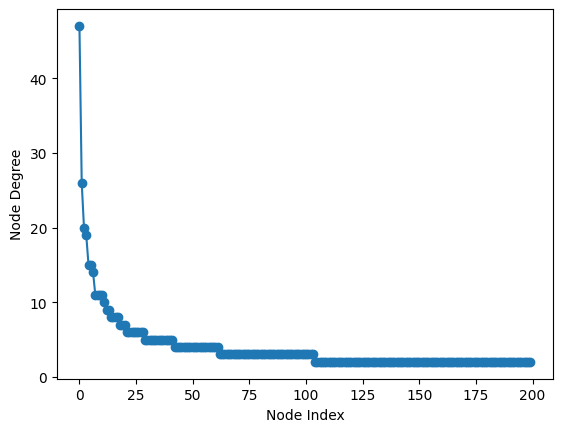

In [19]:
#num_nodes = 10000
#mean_degree = 8
#graph = ba_graph(num_nodes, mean_degree)
#degrees = dict(graph.degree())
#degree_list = [degrees[node] for node in range(num_nodes)]
#fig, ax = plt.subplots()
#ax.plot(range(num_nodes), degree_list, marker='o', linestyle='-')
#ax.set_xlabel('Node Index')
#ax.set_ylabel('Node Degree')

Text(0.5, 1.0, 'Evolution repeated 10 times on the same graph')

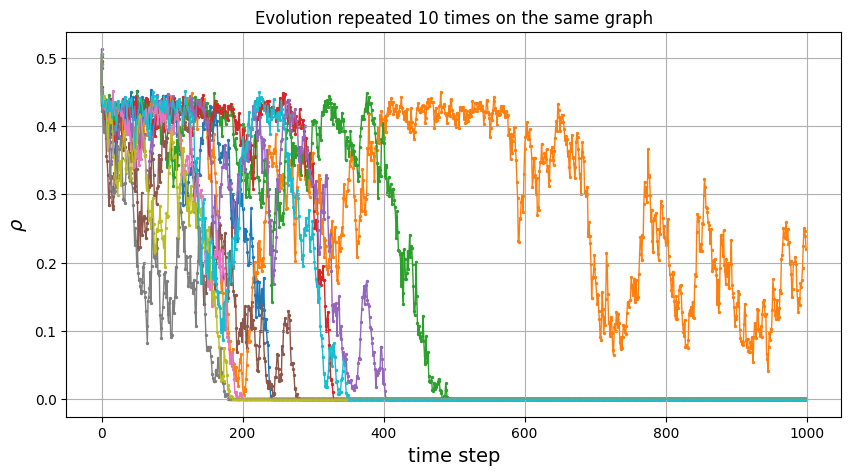

In [77]:
number_of_steps = 1000
num_nodes = 1000
mean_degree = 8
graph = ba_graph(num_nodes, mean_degree)
n_realizations = 10

fig, ax = plt.subplots(figsize = (10, 5))

for n in range(n_realizations):
    data = []
    state = initial_state(num_nodes)
    data.append({'step': 0, 'rho': rho(graph, state)})
    for t in range(number_of_steps):
        state = evolution_step(graph, state)
        data.append({'step': t, 'rho': rho(graph, state)})
    df = pd.DataFrame(data)
    df.to_csv(f"csv_outputs/BA_instance_{n}.csv")
    ax.plot(df['step'], df['rho'], linewidth = 1, alpha = 1)
    ax.scatter(df['step'], df['rho'], s = 2)
ax.grid()
ax.set_ylabel(r"$\rho$", fontsize = 14)
ax.set_xlabel("time step", fontsize = 14)
ax.set_title(f"Evolution repeated {n_realizations} times on the same graph")

Text(0.5, 1.0, 'Evolution repeated only once on 10 different network instances')

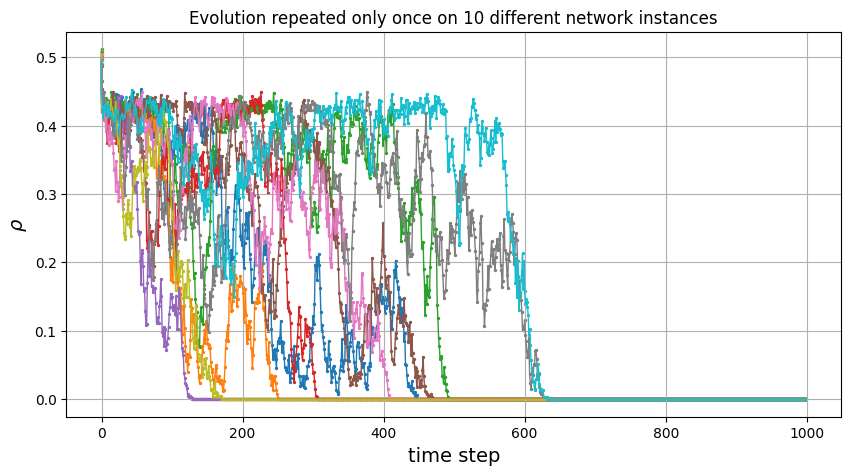

In [84]:
number_of_steps = 1000
num_nodes = 1000
mean_degree = 8
n_realizations = 10

fig, ax = plt.subplots(figsize = (10, 5))

for n in range(n_realizations):
    data = []
    graph = ba_graph(num_nodes, mean_degree)
    state = initial_state(num_nodes)
    data.append({'step': 0, 'rho': rho(graph, state)})
    for t in range(number_of_steps):
        state = evolution_step(graph, state)
        data.append({'step': t, 'rho': rho(graph, state)})
    df = pd.DataFrame(data)
    df.to_csv(f"csv_outputs/BA_instance_{n}.csv")
    ax.plot(df['step'], df['rho'], linewidth = 1, alpha = 1)
    ax.scatter(df['step'], df['rho'], s = 2)
ax.grid()
ax.set_ylabel(r"$\rho$", fontsize = 14)
ax.set_xlabel("time step", fontsize = 14)
ax.set_title(f"Evolution repeated only once on {n_realizations} different network instances")

## Survival time scaling with network size

Question: repeating evolution n times on the same instance of the BA model is the same as repeating evolution exactly once on n different instances?
Might it be that the specific BA instance is somewhat peculiar and does not represent well its ensemble?
I think it is possible.

In the following, I create n_realization different instances of the graph. Also, the random initial state is different for each of them

In [5]:
n_realizations = 500
mean_degree = 6
network_sizes = [1000, 2000, 5000, 10000, 20000, 50000]
time_steps = 1000
df = pd.DataFrame({'time': [t for t in range(time_steps)]})
rho_data = {}

small_sizes = [np.power(2, i) for i in np.arange(9, 10)]
for size in small_sizes:
    for n in range(n_realizations):
        graph = ba_graph(num_nodes= size, mean_degree=mean_degree)
        state = initial_state(num_nodes= size)
        rho_list = []
        for t in range(time_steps):
            state = evolution_step(graph, state)
            rho_list.append(rho(graph, state))
        rho_data[f'instance_{n+1}'] = rho_list
        print(f"size {size}, realization n {n}")
    rho_df = pd.DataFrame(rho_data) # adding columns all at once avoids fragmentation issue and improves performance
    df = pd.concat([df, rho_df], axis=1)
    df['mean'] = df.iloc[:, 1:].mean(axis=1) #calculates row mean, for each row in dataframe
    df.to_csv(f"csv_outputs/size_{size}_n_{n_realizations}.csv", index=False)

size 512, realization n 0
size 512, realization n 1
size 512, realization n 2
size 512, realization n 3
size 512, realization n 4
size 512, realization n 5
size 512, realization n 6
size 512, realization n 7
size 512, realization n 8
size 512, realization n 9
size 512, realization n 10
size 512, realization n 11
size 512, realization n 12
size 512, realization n 13
size 512, realization n 14
size 512, realization n 15
size 512, realization n 16
size 512, realization n 17
size 512, realization n 18
size 512, realization n 19
size 512, realization n 20
size 512, realization n 21
size 512, realization n 22
size 512, realization n 23
size 512, realization n 24
size 512, realization n 25
size 512, realization n 26
size 512, realization n 27
size 512, realization n 28
size 512, realization n 29
size 512, realization n 30
size 512, realization n 31
size 512, realization n 32
size 512, realization n 33
size 512, realization n 34
size 512, realization n 35
size 512, realization n 36
size 512, r

A note of mine: I see that rho in the initial condition, averaged over the ensemble, has a fleble but visible dependence on N. It increases with N. 
I thought that I should have expected a constant value of rho = 0.5.
But thinking more carefully, rho actually measures the number of links at the interface, not the number of up/down spins directly. For smaller networrks, boundaries are more important. I think this is the reason why rho increases monotonically with size, and i expect that it whould be 0.5 in the infinite size limit.

You cannot fix the whole exponential because log(0) = -infty

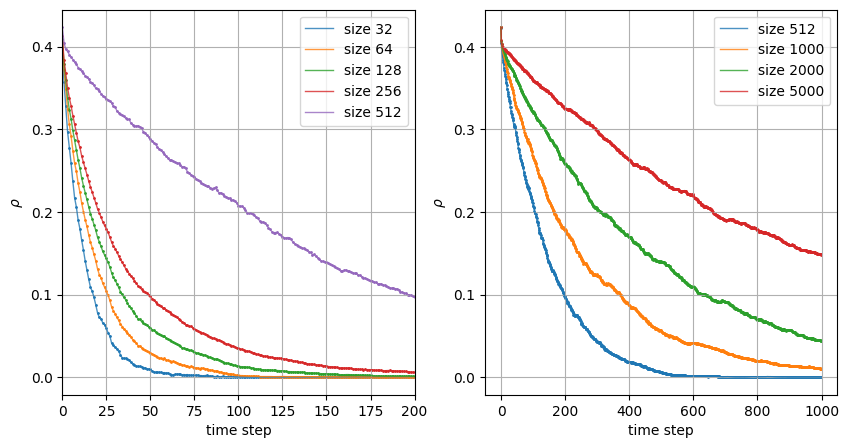

In [53]:
## Visualization of the simulation results ##
## Needed to select the right segment of data for exponential fit

fig, (ax1, ax2) = plt.subplots (1, 2, figsize = (10, 5))

small_sizes = [np.power(2, i) for i in np.arange(5, 10)]
big_sizes = [512, 1000, 2000, 5000]

for s in small_sizes:
    df = pd.read_csv(f"csv_outputs/size_{s}_n_{500}.csv")
    ax1.plot(df['time'], df['mean'], linewidth = 1, label = f"size {s}", alpha = 0.8)
    ax1.scatter(df['time'], df['mean'], linewidth = 1, s = 1)
    ax1.set_xlabel('time step')
    #ax1.set_xscale('log')
    ax1.set_ylabel(r'$\rho$')
    ax1.legend()
    ax1.set_xlim([0,200])

for s in big_sizes:
    df = pd.read_csv(f"csv_outputs/size_{s}_n_{500}.csv")
    ax2.plot(df['time'], df['mean'], linewidth = 1, label = f"size {s}", alpha = 0.8)
    ax2.scatter(df['time'], df['mean'], linewidth = 1, s = 1)
    ax2.set_xlabel('time step')
    #ax2.set_xscale('log')
    ax2.set_ylabel(r'$\rho$')
    ax2.legend()

ax1.grid()
ax2.grid()

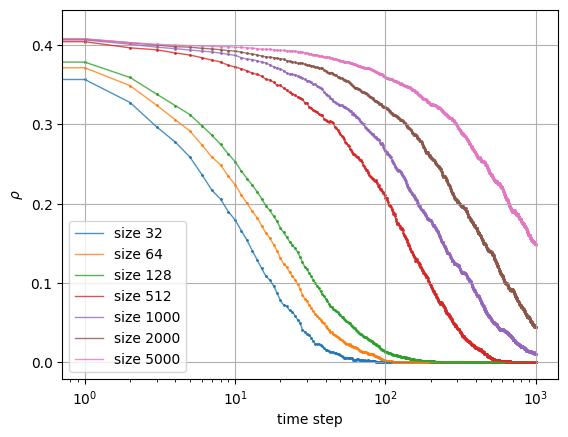

In [54]:
sizes = [32, 64, 128, 512, 1000, 2000, 5000]
endings = [50, 75, 150, 400, 1000, 1000, 1000]
data = []

fig, ax = plt.subplots()

for i, s in enumerate(sizes):
    df = pd.read_csv(f"csv_outputs/size_{s}_n_{500}.csv")
    ax.plot(df['time'], df['mean'], linewidth = 1, label = f"size {s}", alpha = 0.8)
    ax.scatter(df['time'], df['mean'], linewidth = 1, s = 1)
    ## exponential fit ##
    x = df['time'].iloc[10:endings[i]].values.reshape(-1, 1)
    y = np.log(df['mean'].iloc[10:endings[i]].values)
    X = sm.add_constant(x)  # this means i also want the intercept
    model = sm.OLS(y, X).fit()
    params = model.params  # a + b * x
    standard_errors = model.bse
    eta = np.exp(params[0])
    sigma_eta = eta * standard_errors[0]
    tau =  - 1 / params[1]
    sigma_tau = np.square(tau) * standard_errors[1]
    data.append({'size': s, 'tau': tau, 'sigma_tau': sigma_tau, 'eta': eta, 'sigma_eta': sigma_eta})

df = pd.DataFrame(data)


df.to_csv("csv_outputs/BA_node_update_rule_results.csv")

ax.set_xlabel('time step')
ax.set_xscale('log')
ax.set_ylabel(r'$\rho$')
ax.legend()
ax.grid()
plt.savefig("figures/BA_node_update_rule_results_logscale.pdf")

intercept= 29.233734213413012, slope= 0.19612752212071127


/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_885/1118098019.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(x, [params[0] + params[1] * x for x in x], linewidth = 1, color = 'red')
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_885/1118098019.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"intercept= {params[0]}, slope= {params[1]}")


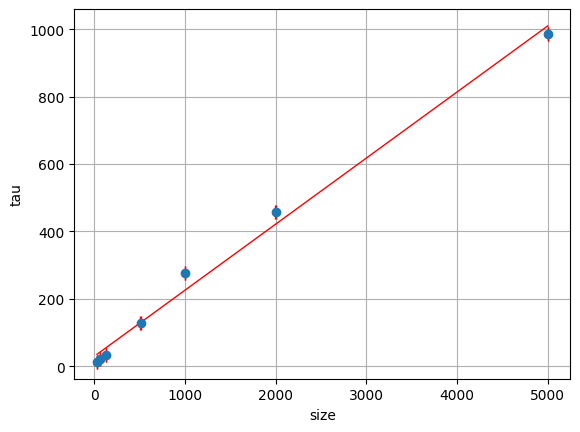

In [62]:
df = pd.read_csv("csv_outputs/BA_node_update_rule_results.csv")
fig, ax = plt.subplots()
ax.set_xlabel("size")
ax.set_ylabel("tau")
ax.grid()
# Create a scatter plot with error bars
x = df['size']
y = df['tau']
ax.errorbar(x, y, xerr=df['sigma_tau'], fmt='o', ecolor='r', capsize=5)
# Linear Fit
X = sm.add_constant(x)  # this means i also want the intercept
model = sm.OLS(y, X).fit()
params = model.params  # a + b * x
standard_errors = model.bse
ax.plot(x, [params[0] + params[1] * x for x in x], linewidth = 1, color = 'red')
print(f"intercept= {params[0]}, slope= {params[1]}")

8.670814376710534e-05


<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_885/2596343683.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(x_data, y_fit, label=f'{gamma_fit:.2f} $\pm$ {gamma_std:.2f}', color='red')


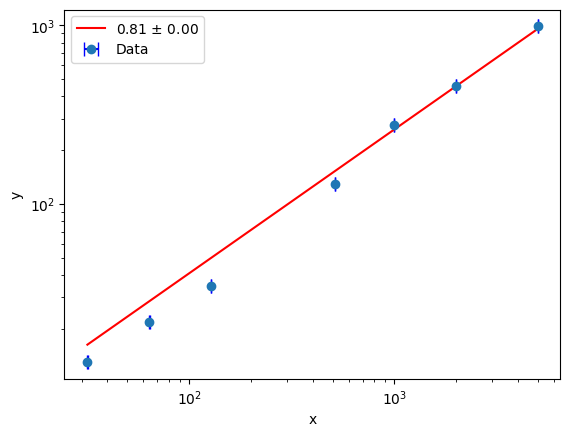

In [79]:
from scipy.optimize import curve_fit

x_data = df['size']
y_data = df['tau']
y_uncertainties = df['sigma_tau']
# Define the power law function
def power_law(x, gamma):
    return x ** gamma

# Fit the power law model to the data
params, covariance = curve_fit(power_law, x_data, y_data, sigma=y_uncertainties, absolute_sigma=True)

# Extract the fitted parameter
gamma_fit = params[0]
gamma_std = np.sqrt(covariance[0,0])
print(gamma_std)
# Generate y values from the fitted model
y_fit = power_law(x_data, gamma_fit)

fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, xerr= y_uncertainties, fmt='o', ecolor='b', capsize=5 , label = "Data")
ax.plot(x_data, y_fit, label=f'{gamma_fit:.2f} $\pm$ {gamma_std:.2f}', color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()